In [1]:
import gym
import pygame
import numpy as np
import custom_frozen_lake
import time

import random
import matplotlib.pyplot as plt
%matplotlib widget
from pathlib import Path
import pandas as pd
from datetime import datetime
from IPython.display import clear_output
import winsound

pygame.init(); 

DIR_STATE_FLAG = True

In [2]:
def test_map_generation(manual: bool=False):
    for i in range(1):
        env = gym.make(id='CustomFrozenLake', desc = None, map_name = None, map_size = 6, frozen_p = 0.6)
        print(env.reset())
        env.render()
        while(manual):
            event = pygame.event.wait()
            if event.type == pygame.KEYDOWN:
                break
        if not manual: time.sleep(1)
    env.close()

In [3]:
def test_actions(manual: bool=False):
    env = gym.make(id='CustomFrozenLake', desc = None, map_name = None, map_size = 6, frozen_p = 0.6)
    env.reset()
    for i in range(20):
        env.render()
        while(manual):
            event = pygame.event.wait()
            if event.type == pygame.KEYDOWN:
                break
        if not manual: time.sleep(1)
        
        action = env.action_space.sample()
        obs, reward, done,_ = env.step(action)
        print(obs, reward, action)
        if done:
            break
    env.close()

In [4]:
# test_map_generation()
# test_actions(1)

In [5]:
def set_up(map_size: int = 8, frozen_p: float = 0.7):
    b_slip = True

    env = gym.make(id='CustomFrozenLake', is_slippery=b_slip, desc = None, map_name = None, map_size = map_size, frozen_p = frozen_p)
    action_size = env.action_space.n

    if DIR_STATE_FLAG: state_size = (env.observation_space[0].n, env.observation_space[1].n) 
    else: state_size = env.observation_space.n

    if DIR_STATE_FLAG: qtable = np.zeros(state_size + (action_size,))
    else: qtable = np.zeros((state_size, action_size))
    #print(action_size, state_size)
    return (env, qtable)

In [19]:
def write_file(path: Path, file_name: str, array: np.ndarray = None, 
                column_label: np.ndarray = None, row_label: np.ndarray = None, qtable: np.ndarray = None):

    #file_name = (str(total_episodes) +'_'+ str(learning_rate) +'_'+ str(gamma) +'_'+
                 #str(min_epsilon) +'_'+ str(decay_rate))
                 
    path.mkdir(exist_ok=True, parents=True)
    # with open (file_name+'.txt', 'w') as f:
    #     f.write('Total reward in final 1000 episodes: ' + str(rewards_1000[-1]) + '\n' +
    #             'Total episodes: ' + str(total_episodes) + '\n' +
    #             'Learning rate: ' + str(learning_rate) + '\n' +
    #             'Gamma: ' + str(gamma) + '\n' +
    #             'Min epsilon: ' + str(min_epsilon) + '\n' +
    #             'Decay rate: ' + str(decay_rate)
    #               )
    try:
        array.shape   
        df = pd.DataFrame(array)
        if column_label.size == array.shape[1]: df.columns = column_label
        if row_label.size == array.shape[0]: df.index = row_label
        df.to_csv(path/(file_name + '.csv')) 
    except: pass
    
    try:
        qtable.shape
        np.save(path/(file_name + '.npy'), qtable)
    except: return
    # plt.plot(np.arange(0, total_episodes/1000), rewards_1000)
    # plt.savefig(map + '\\'+file_name +'.png')
    # plt.close

In [7]:
def train_model(env: gym.Env, qtable: np.ndarray, manual: bool = False, frozen_p: float = 0.8,
                total_episodes: int=20000, learning_rate: float=0.6, max_steps: int=200, gamma: float=0.6, 
                epsilon: float=1, max_epsilon: float=1, min_epsilon: float=0, decay_rate: float=0.00005) -> list:
    
    render_interval = total_episodes // 10

    ep_reward = []
    rewards_1000 = []
    ep_steps = []
    steps_1000 = []
    win = 0

    for episode in range(total_episodes):
        # Reset the environment
        state = env.reset()
        done = False
        total_rewards = 0
        if episode % 20000 == 0:
            clear_output(True)
            print(datetime.now().strftime("%H:%M"), "Don't worry, still alive. Episode:", episode)
            
        for step in range(max_steps):
            # Choose an action a in the current world state (s)
            ## First we randomize a number
            exp_exp_tradeoff = random.uniform(0, 1)
            
            ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
            if exp_exp_tradeoff > epsilon:
                action = np.argmax(qtable[state])
                # print(episode, step, state, action)
            # Else doing a random choice --> exploration
            else:
                action = env.action_space.sample()

            # Take the action (a) and observe the outcome state(s') and reward (r)
            new_state, reward, done, info = env.step(action)


            if episode % render_interval == 0:
                #env.render()
                while(manual):
                    event = pygame.event.wait()
                    if event.type == pygame.KEYDOWN:
                        break
                if not manual: time.sleep(0.5)

            # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
            # qtable[new_state,:] : all the actions we can take from new state

            # print(episode, step, state, action)
            if DIR_STATE_FLAG: qtable[state + (action,)] = qtable[state + (action,)] + learning_rate * (reward + gamma * np.max(qtable[new_state]) - qtable[state + (action,)])
            else: qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])

            total_rewards += reward
            if reward > 0: win += 1
            
            # Update state
            state = new_state

            # Finish episode if agent reaches reward or hole
            if done == True: 
                ep_steps.append(step + 1)
                break
            
        # Reduce epsilon (because we need less and less exploration)
        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode) 
        ep_reward.append(total_rewards)
        if not done: ep_steps.append(step + 1)
        env, _ = set_up(frozen_p=frozen_p)

    rewards_1000 = np.add.reduceat(ep_reward, np.arange(0, len(ep_reward), 1000))
    steps_1000 = np.add.reduceat(ep_steps, np.arange(0, len(ep_reward), 1000))/1000
    print(steps_1000)
    #print(rewards_1000[-1])
    #print(epsilon)
    #write_files(qtable, rewards_1000, total_episodes, learning_rate, gamma, min_epsilon, decay_rate)
    env.close()
    print(win)
    winsound.Beep(440, 500)
    return qtable, rewards_1000

In [8]:
def test_model(env: gym.Env, qtable: np.ndarray, manual: bool=True, max_steps: int=100, frozen_p: float = 0.8):
    total_reward = 0
    win = 0
    total_episodes = 100
    render_interval = total_episodes // 5
    
    for episode in range(total_episodes):
        state = env.reset()
        step = 0
        done = False
        print("****************************************************")
        print("EPISODE ", episode)

        for step in range(max_steps):
            # Take the action (index) that have the maximum expected future reward given that state
            action = np.argmax(qtable[state])
            # print(episode, step, state, action)
            
            new_state, reward, done, info = env.step(action)
            if episode % render_interval == 0:
                env.render()
                while(manual):
                    event = pygame.event.wait()
                    if event.type == pygame.KEYDOWN:
                        break
                if not manual: time.sleep(.3)
            if done:
                # Here, we decide to only print the last state (to see if our agent is on the goal or fall into an hole)

                # We print the number of step it took.
                print("Number of steps", step + 1)
                print("Reward:", reward)
                total_reward += reward
                if reward > 0: win += 1
                break
            state = new_state
        if not done: print("Timed out", step + 1, "steps")
        env, _ = set_up(frozen_p=frozen_p)
    print('Total rewards:', total_reward)
    print('Success rate:', win,'/',total_episodes)
    env.close()

In [9]:
def tune_hyperparam(env: gym.Env, qtable: np.ndarray, total_episodes: int = 20000, frozen_p: float = 0.8):
    interval = 10
    interval2 = 10
    parameter_range = np.linspace(0.1,0.9,interval,endpoint=True)
    parameter_range2 = np.linspace(0.1,0.9,interval2,endpoint=True)
    rewards = []
    
    min_epsilon, max_epsilon = 0.0, 1.0
    decay_rate = -(np.log((0.1 - min_epsilon) / (max_epsilon - min_epsilon))) / total_episodes

    for i in range(1):
        for parameter in parameter_range:
            for parameter2 in parameter_range2:
                # reset qtable
                qtable = np.zeros(qtable.shape)
                qtable, rewards_1000 = train_model(env, qtable, False, frozen_p, total_episodes, max_steps=100,
                                                    learning_rate=parameter, gamma=parameter2, 
                                                    min_epsilon=min_epsilon, max_epsilon=max_epsilon, decay_rate=decay_rate)
                rewards.append(rewards_1000[-1])
    rs_rewards = np.reshape(rewards,(-1,interval,interval2))
    rs_rewards_mean = np.mean(rs_rewards, axis=0)

    now = datetime.now().strftime('%Y%m%d-%H%M')
    path = Path('tune_hyperparam/'+ str(now))
    param_list = [total_episodes, min_epsilon, max_epsilon, decay_rate]
    file_name = '_'.join(map(str, param_list))

    write_file(path, file_name, rs_rewards_mean, parameter_range, parameter_range2)


In [10]:
def test_write_file():
    path = Path('test/test2')
    file_name = 'testfile'
    array2 = np.arange(0,12)
    array2 = array2.reshape((3,4))
    row = np.arange(3,6)
    col = np.arange(4,8)
    write_file(path, file_name, array2, col, row)

In [11]:
# frozen_p = 0.8
# env, qtable = set_up(frozen_p = frozen_p)
# tune_hyperparam(env, qtable, frozen_p = frozen_p)

01:30 Don't worry, still alive. Episode: 1480000
[ 9.333  9.752  9.189 ... 24.807 25.241 29.135]
260456
[ -6.5  -7.6  -8.7 ... 196.6 206.3 182.3]
[[[ 0.00832712  0.00783399  0.00796178  0.00773155]
  [ 0.09452353  0.0025469   0.00474692  0.00500547]
  [ 0.00388908  0.0039745   0.0712984   0.0039772 ]
  [ 0.01522105  0.02550018  0.01475897  0.03441073]]

 [[-0.00664264  0.00357877  0.01183598 -0.0097132 ]
  [-0.00546291 -0.02710899  0.01557703  0.00365313]
  [-0.01796196 -0.00373615  0.02687258 -0.02007995]
  [-0.02196683 -0.01263052  0.04744703 -0.0200941 ]]

 [[-0.0199967   0.00211108 -0.014419    0.01422403]
  [-0.03517071 -0.03779025 -0.02057458  0.00513528]
  [-0.01134966 -0.00685582 -0.00873054  0.01262074]
  [-0.02013208 -0.01274331  0.00301057  0.121067  ]]

 [[-0.02723587 -0.04681558 -0.0082444  -0.04525691]
  [-0.03387688 -0.0360164  -0.0350295  -0.02184664]
  [-0.0496065  -0.04319333 -0.03944805 -0.02155544]
  [-0.05508121 -0.04378028 -0.03452804  0.00127184]]

 [[ 0.01709836

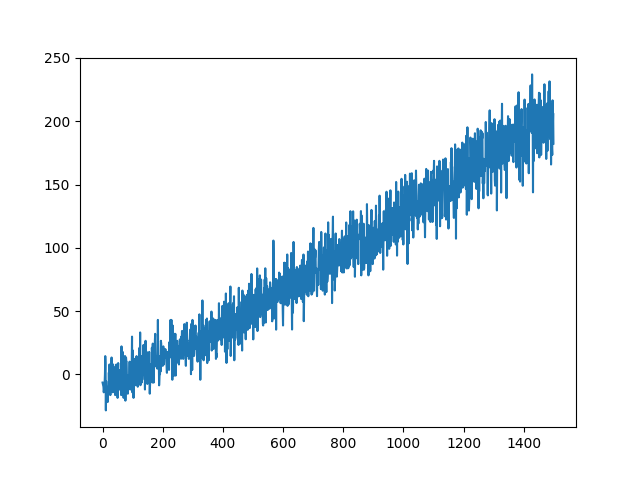

In [12]:
frozen_p = 0.8
env, qtable = set_up(frozen_p=frozen_p)
total_episodes = 1_500_000
min_epsilon, max_epsilon = 0.0, 1.0
learning_rate = 0.1
gamma = 0.6667

# calculate decay_rate needed to achieve 90% exploit chance at the final episode
decay_rate = -(np.log((0.1 - min_epsilon) / (max_epsilon - min_epsilon))) / total_episodes

qtable, rewards_1000 = train_model(env, qtable, False, frozen_p, total_episodes, learning_rate, gamma=gamma,
                                    min_epsilon=min_epsilon, max_epsilon=max_epsilon, decay_rate=decay_rate)

now = datetime.now().strftime('%Y%m%d-%H%M')
path = Path('training/'+ str(now))
param_list = [total_episodes, min_epsilon, max_epsilon, decay_rate, learning_rate, ]
file_name = '_'.join(map(str, param_list))

write_file(path, file_name, qtable=qtable)                        
print(rewards_1000)

env, _ = set_up(frozen_p=frozen_p)
print(qtable)
test_model(env, qtable, False)

plt.plot(rewards_1000)

In [13]:
# frozen_p = 0.8
# env, _ = set_up(frozen_p=frozen_p)
# qtable = np.load('custom_test.npy')
# print(qtable)
# test_model(env, qtable, False, frozen_p=frozen_p)

In [24]:
env, _ = set_up()
print(qtable)
test_model(env, qtable, False)

[[[ 0.00832712  0.00783399  0.00796178  0.00773155]
  [ 0.09452353  0.0025469   0.00474692  0.00500547]
  [ 0.00388908  0.0039745   0.0712984   0.0039772 ]
  [ 0.01522105  0.02550018  0.01475897  0.03441073]]

 [[-0.00664264  0.00357877  0.01183598 -0.0097132 ]
  [-0.00546291 -0.02710899  0.01557703  0.00365313]
  [-0.01796196 -0.00373615  0.02687258 -0.02007995]
  [-0.02196683 -0.01263052  0.04744703 -0.0200941 ]]

 [[-0.0199967   0.00211108 -0.014419    0.01422403]
  [-0.03517071 -0.03779025 -0.02057458  0.00513528]
  [-0.01134966 -0.00685582 -0.00873054  0.01262074]
  [-0.02013208 -0.01274331  0.00301057  0.121067  ]]

 [[-0.02723587 -0.04681558 -0.0082444  -0.04525691]
  [-0.03387688 -0.0360164  -0.0350295  -0.02184664]
  [-0.0496065  -0.04319333 -0.03944805 -0.02155544]
  [-0.05508121 -0.04378028 -0.03452804  0.00127184]]

 [[ 0.01709836 -0.00523567  0.00119243  0.00135045]
  [ 0.09706018 -0.00562682 -0.01283942 -0.05068749]
  [ 0.01611065 -0.01916362 -0.02084962 -0.0135046 ]
  [ 

In [15]:
# np.save('custom_test.npy' ,qtable)

In [16]:
# qload = np.load('custom_test.npy')